In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-compass/')
from compass.utils import plot_embed_with_label
from compass import PreTrainer, FineTuner, loadcompass
from compass.utils import plot_embed_with_label, score
from compass.tokenizer import CANCER_CODE, CONCEPT

In [2]:
from compass.tokenizer import CONCEPT_palette
from compass.utils import plot_sankey_diagram, get_projector_weights

In [18]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from shap.plots import colors
palette =  [colors.blue_rgb,colors.red_rgb]

In [4]:
data_path = '../../00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE.ALIGN'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape


((1133, 15672), (1133, 26))

In [36]:
def km_plot(df, colormap= {'Low-risk':colors.blue_rgb, 'High-risk':colors.red_rgb}, cohort='IMvigor210'):
    from lifelines.statistics import logrank_test
    from lifelines import KaplanMeierFitter
    import matplotlib.pyplot as plt
    
    # 分组数据
    group_1 = df[df['Pred_Risk'] == 'Low-risk']
    group_2 = df[df['Pred_Risk'] == 'High-risk']

    # 计算 Log-Rank 检验的 p 值
    results = logrank_test(
        group_1['OS_Months'], group_2['OS_Months'],
        event_observed_A=group_1['OS_Event'],
        event_observed_B=group_2['OS_Event']
    )
    p_value = results.p_value
    formatted_p_value = f"{p_value:.2g}"  # 保留 2 位有效小数
    
    # 绘制 Kaplan-Meier 曲线
    kmf = KaplanMeierFitter()
    fig, ax = plt.subplots(figsize=(5.5, 5))
    
    for group in df['Pred_Risk'].unique():
        # 获取分组索引和样本数
        group_idx = df['Pred_Risk'] == group
        n_samples = group_idx.sum()  # 当前组样本数
        
        # 拟合数据
        kmf.fit(
            durations=df['OS_Months'][group_idx],
            event_observed=df['OS_Event'][group_idx]
        )
        kmf.plot_survival_function(
            ax=ax,
            color=colormap[group],
            label=f'{group} (n = {n_samples})',
            show_censors=True,
            ci_show=True,
            ci_alpha=0.1,
            drawstyle='steps-post'
        )
        
        # 获取 12 月的生存率和置信区间
        time_point = 12
        survival_rate = kmf.predict(time_point)
        ci = kmf.confidence_interval_.asof(time_point)
        lower_ci = ci['KM_estimate_lower_0.95']
        upper_ci = ci['KM_estimate_upper_0.95']
        
        # 打印 12 月生存率和置信区间
        print(f"12-month survival rate for {group}: {survival_rate:.2f} (95% CI: {lower_ci:.2f}-{upper_ci:.2f})")

    # 添加 12 月的竖直虚线
    ax.axvline(x=12, color='black', linestyle='--', linewidth=1, alpha=0.8)
    
    # 添加 p 值到图表顶部
    formatted_p_value = f"{p_value:.1e}".replace("e", r" \times 10^{").replace("+", "").replace("-", r"-") + "}$"
    formatted_p_value = f"$P = {formatted_p_value}"
    ax.set_title(f"{cohort}\nLog-Rank Test {formatted_p_value}", pad=20)
    
    # 修改坐标轴
    ax.set_xlabel("Time (Months)")
    ax.set_ylabel("Overall Survival (%)")
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}'))
    
    ax.set_xlim(left=0)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='both', which='major', right=False, top=False, direction='out', reset=True)
    ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.spines[['right', 'top']].set_visible(False)
    
    return fig


In [6]:
# load the pretrained model as a feature extractor
finetuner = loadcompass('https://www.immuno-compass.com/download/model/LOCO/pft_leave_IMVigor210.pt')
#finetuner = loadcompass('https://www.immuno-compass.com/download/model/pretrainer.pt')
genesetprojector = finetuner.model.latentprojector.genesetprojector
cellpathwayprojector = finetuner.model.latentprojector.cellpathwayprojector
df_tpm = df_tpm[finetuner.feature_name]
finetuner.count_parameters()

Downloading...
From: https://www.immuno-compass.com/download/model/LOCO/pft_leave_IMVigor210.pt
To: /tmp/tmp4s1d67y_
100%|██████████| 35.1M/35.1M [01:44<00:00, 336kB/s] 


Model downloaded to: /tmp/tmp4s1d67y_


2389

In [7]:
dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfgn, dfgs, dfct = finetuner.extract(dfcx,  batch_size= 128, with_gene_level = True)
_, dfpred = finetuner.predict(dfcx,  batch_size= 64,)

100%|##########| 18/18 [00:02<00:00,  6.92it/s]


In [20]:
cohort = 'IMVigor210'

In [8]:
tr = df_label[df_label.cohort != cohort]
tr = tr[(~tr.OS_Months.isna()) & (~tr.OS_Event.isna())]
tr.cohort.unique()

array(['Rose', 'Snyder', 'SU2CLC1', 'SU2CLC2', 'Hugo', 'Gide', 'Liu',
       'Riaz', 'Allen', 'MGH'], dtype=object)

In [9]:
ts = df_label[df_label.cohort == cohort]

In [10]:
print(len(tr), len(ts))

562 298


In [11]:
X = dfgs

y_train = tr[['OS_Months', 'OS_Event']]
X_train = X.loc[tr.index]

y_test = ts[['OS_Months', 'OS_Event']]
X_test = X.loc[ts.index]

features = X.columns

X_scaler = StandardScaler().set_output(transform="pandas")
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

data_train = X_train.join(y_train)
data_test = X_test.join(y_test)

{'alphas': 136.6716356462007, 'average_cindex': 0.6378503748431461}


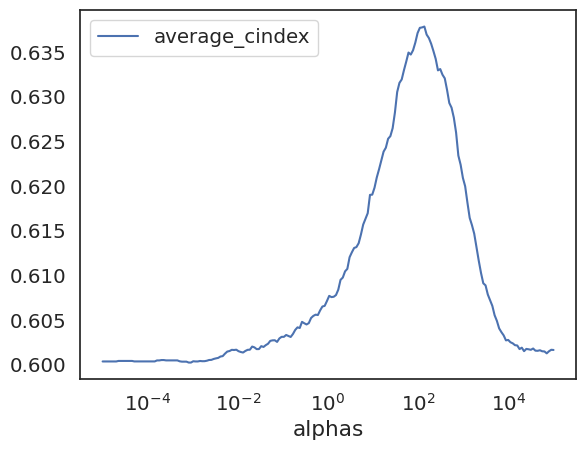

In [12]:
alphas = list(10. ** np.linspace(-5, 5, 200))
# x = np.linspace(0, 1, 100)  # 线性采样
# transformed_x = x**2  # 在 0-1 之间更加密集的变换
# alphas = 10.0 ** np.concatenate([transformed_x, np.linspace(1, 5, 100)])  # 扩展到 10^-5 到 10^5
score_params = []

for j in range(len(alphas)):
    params={}
    cindex=[]
    for i in range(5):
    
        data_test_80=np.array_split(data_train, 5)[i]
        X_test_80 = pd.DataFrame(data_test_80, columns=features)
        y_test_80 = pd.DataFrame(data_test_80, columns=['OS_Event','OS_Months'])
        y_test_80['OS_Event'] = y_test_80['OS_Event'].replace({0: False, 1: True})
        y_test_80 = y_test_80.to_records(index=False)
        
        test_id=data_test_80.index
        data_train_80=data_train[~data_train.index.isin(test_id)]
  
        X_train_80 = pd.DataFrame(data_train_80, columns=features)
        y_train_80 = pd.DataFrame(data_train_80, columns=['OS_Event','OS_Months'])
        y_train_80['OS_Event'] = y_train_80['OS_Event'].replace({0: False, 1: True})
        y_train_80 = y_train_80.to_records(index=False)
        
        coxph = CoxPHSurvivalAnalysis(alpha=alphas[j])
        coxph.fit(X_train_80, y_train_80)
        coxph_predict = coxph.predict(X_test_80)
    
        y_test_80 = pd.DataFrame(data_test_80, columns=['OS_Event', 'OS_Months'])
        y_test_80['OS_Event'] = y_test_80['OS_Event'].replace({0: False, 1: True})
    
        cind = concordance_index_censored(np.array(y_test_80['OS_Event']), np.array(y_test_80['OS_Months']), coxph_predict)
        cindex.append(cind[0])
        
    mean = sum(cindex)/len(cindex)
    #print(mean)
    params['alphas'] = alphas[j]
    params['average_cindex'] = mean
    score_params.append(params)

maxCindex = max(score_params, key=lambda x:x['average_cindex'])
print(maxCindex)

fig, ax = plt.subplots()
pd.DataFrame(score_params).set_index('alphas').plot(ax=ax)
ax.set_xscale('log')

AUC (Area Under the Curve): 0.7658
Best Threshold (ROC): 0.4749266890768812
12-month survival rate for High-risk: 0.58 (95% CI: 0.54-0.62)
12-month survival rate for Low-risk: 0.93 (95% CI: 0.82-0.97)


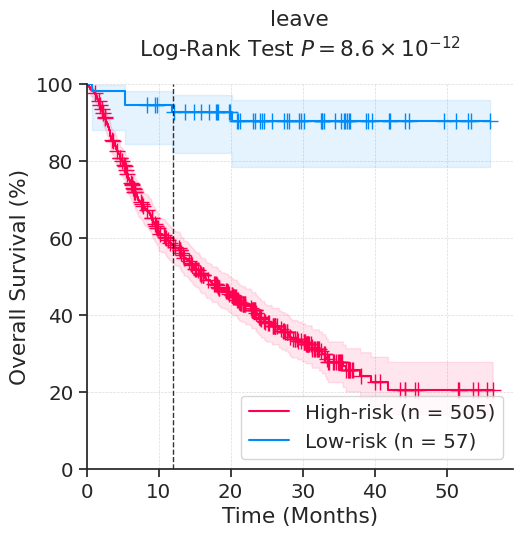

In [37]:
y_train = pd.DataFrame(data_train, columns=['OS_Event','OS_Months'])
y_train['OS_Event'] = y_train['OS_Event'].replace({0: False, 1: True})
y_train = y_train.to_records(index=False)

coxph = CoxPHSurvivalAnalysis(alpha=maxCindex['alphas']) #maxCindex['alphas']
coxph.fit(X_train, y_train)

# 假设以下是你的输入数据
# predicted_risk: Cox 模型对训练数据的预测风险值
# true_label: 训练数据的真实标签 (1: 死亡, 0: 存活)
true_label = y_train['OS_Event']  # 真实标签 (1: 死亡, 0: 存活)

df = pd.DataFrame.from_records(y_train)
df['risk_score'] =  coxph.predict(X_train)# 使用 Cox 模型对训练集进行预测
scaler = MinMaxScaler().set_output(transform="pandas")
df[['risk_score']] = scaler.fit_transform(df[['risk_score']])
predicted_risk = df.risk_score.values


# Step 1: 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(true_label, predicted_risk)

# Step 2: 计算 AUC
auc = roc_auc_score(true_label, predicted_risk)
print(f"AUC (Area Under the Curve): {auc:.4f}")

# Step 3: 计算 Youden's J statistic，找到最佳阈值
youden_index = np.argmax(tpr - fpr)  # 最大化 TPR - FPR
best_threshold = thresholds[youden_index]
print(f"Best Threshold (ROC): {best_threshold}")

best_threshold = df['risk_score'].quantile(0.1)

df['Pred_Risk'] = df['risk_score'].apply(lambda x: 'High-risk' if x >= best_threshold else 'Low-risk')
df['Pred_Risk'].value_counts()

fig = km_plot(df, cohort = 'leave')

In [38]:
best_threshold

0.2596043731871968

In [40]:
# Step 2: 预测测试集的风险值
predicted_risk_test = coxph.predict(X_test)  # 使用 Cox 模型对测试集进行预测
df = pd.DataFrame.from_records(y_test)
df['risk_score'] = predicted_risk_test
df[['risk_score']] = scaler.transform(df[['risk_score']])


# best_threshold = df['risk_score'].quantile(0.25)
# best_threshold = 0.35 #df['risk_score'].quantile(0.2)

df['Pred_Risk'] = df['risk_score'].apply(lambda x: 'High-risk' if x >= best_threshold else 'Low-risk')
df['Pred_Risk'].value_counts()

Pred_Risk
High-risk    261
Low-risk      37
Name: count, dtype: int64

12-month survival rate for Low-risk: 0.70 (95% CI: 0.53-0.82)
12-month survival rate for High-risk: 0.43 (95% CI: 0.37-0.49)


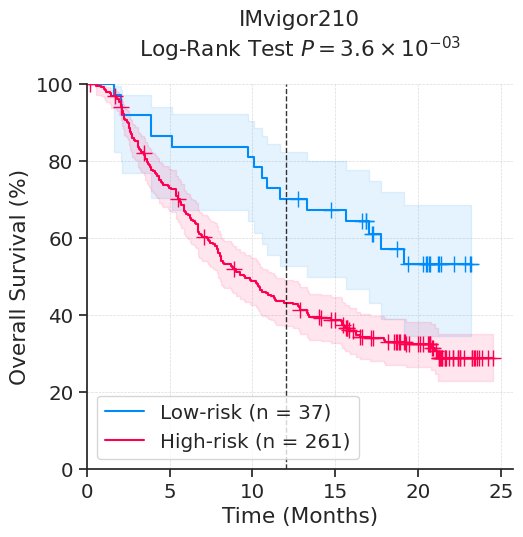

In [41]:
fig = km_plot(df, cohort = 'IMvigor210')
fig.savefig('COX_Geneset_km_%s.pdf' % cohort, bbox_inches='tight',)

In [42]:
df.to_pickle('COX_Geneset_km_%s.pkl' % cohort)